Building a (naive) Spam filer for SMS data.
Download the data from [https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection]

In [44]:
# Import the relevant modules needed for this experiment
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.pipeline import Pipeline


In [2]:
msg_df = pd.read_csv('./data/SMSSpamCollection', sep ="\t", quoting=3, names=['class', 'sms'])
print len(msg_df)

5574


In [3]:
# Sample of the data
msg_df[:10]

,class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
msg_df['class'].value_counts()

ham     4827
spam     747
Name: class, dtype: int64

In [5]:
# Investiagte duplicates in Ham and Spam
ham_ser = msg_df[msg_df['class']=='ham']['sms']
DupsHam_ser = ham_ser[ham_ser.duplicated(keep=False)]
x =len(DupsHam_ser.unique())
print "Number of duplicates found in ham emails: %i" %x

print '\n'
# More detailed summary
print DupsHam_ser.describe()

Number of duplicates found in ham emails: 194


count                        503
unique                       194
top       Sorry, I'll call later
freq                          30
Name: sms, dtype: object


In [6]:
d=dict(DupsHam_ser.value_counts())


EXERCISE: Sort the dictionary above by frequency and print the results to a dataframe for investigation

EXERCISE: Examine the duplicates for the SPAM SMSes

Examine the length of the messages

In [7]:
def text_len(text):
    return len(text)

msg_df['length'] = msg_df['sms'].map(text_len)
msg_df[:10]

,class,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,148
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,158
9,spam,Had your mobile 11 months or more? U R entitle...,154


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000002C46198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C80E1D0>], dtype=object)

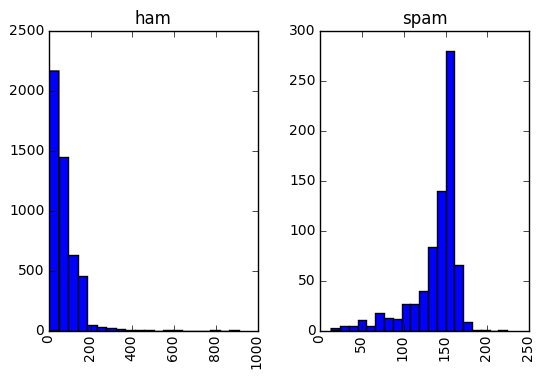

In [8]:
pd.DataFrame.hist(msg_df, column='length', by='class', bins=20)

Study the distribution of lengths of the SPAM SMSes

In [9]:
spam_df = msg_df[msg_df['class']=='spam'][['sms','length']]
spam_df.length.describe()

count    747.000000
mean     139.124498
std       28.996658
min       13.000000
25%      133.000000
50%      149.000000
75%      158.000000
max      224.000000
Name: length, dtype: float64

Feature Engineering

In [10]:
def split_tokens(msg):
    msg = unicode(msg, 'utf8').lower()  
    return TextBlob(msg).words

Example with split_tokens

In [11]:
print msg_df.sms[:6]
print "\n"
print msg_df.sms[:6].apply(split_tokens)

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
Name: sms, dtype: object


0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, goes, to, usf, he...
5    [freemsg, hey, there, darling, it, 's, been, 3...
Name: sms, dtype: object


Study the different techniques in NLP to obtain features from text.
We introduce another technique called Lemmatisation.

In [12]:
def split_lemmas(msg):
    words = split_tokens(msg)
    return [word.lemma for word in words]

msg_df.sms[:6].apply(split_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
5    [freemsg, hey, there, darling, it, 's, been, 3...
Name: sms, dtype: object

Convert to feature matrix before training machine learning models. In Python, scikit-learn is a Python library for machine learning. Used by most people who build machine learning models in Python.

In [13]:
X = CountVectorizer(analyzer=split_lemmas).fit_transform(msg_df['sms'])  

In [14]:
print X.shape
print X.nnz

(5574, 8874)
80272


Apply TF-IDF weighting to the features

In [15]:
Y = TfidfTransformer().fit_transform(X)

Building the machine learning model

Always split the data into training and testing data. Use the training data to fit the model and optimize the parameters. Then report the results(accuracy, precision, recall etc) on the testing set. **Never Never train on the whole set and report the results on the same data**.

In [16]:
msg_train, msg_test, class_train, class_test =\
train_test_split(msg_df['sms'], msg_df['class'], test_size=0.2)

In [17]:
# check the sizes of the training set
print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4459 1115 5574


In [18]:
pipeline = Pipeline([
    ('X', CountVectorizer(analyzer=split_lemmas)),  
    ('Y', TfidfTransformer()),  
    ('model', MultinomialNB())
])

Use cross-validation to check the stability of the training data

In [20]:
scores = cross_val_score(pipeline,  
                         msg_train,  # training data
                         class_train,  # training labels
                         cv=10,  # split data randomly into 5 parts: 4 for training, 1 for scoring
                         scoring='accuracy'
                         )
print scores

[ 0.95749441  0.94630872  0.96196868  0.94394619  0.9529148   0.9573991
  0.94382022  0.95280899  0.95955056  0.94831461]


In [22]:
print scores.mean(), scores.std()

0.952452628379 0.00626827191017


Conclusion: Training data is rather stable

In [24]:
# Train a Naive Bayes model
spam_model = pipeline.fit(msg_train, class_train)

In [30]:
predicted = spam_model.predict(msg_test)
print confusion_matrix(class_test, predicted)
print classification_report(class_test, predicted)

[[964   0]
 [ 62  89]]
             precision    recall  f1-score   support

        ham       0.94      1.00      0.97       964
       spam       1.00      0.59      0.74       151

avg / total       0.95      0.94      0.94      1115



Calculations for precision, recall, $F_1$ score for the ham class

Definition of precision: $$p = \frac{tp}{tp+fp}$$

In [48]:
p=964/(964+62)
print p

0.939571150097


Definition of recall: $$r = \frac{tp}{tp+fn}$$

Definition of $F_1-score$: $$F_1 = 2*\frac{pr}{p+r}$$

In [49]:
print 2*p/(p+1)

0.968844221106


Repeat the calculations for the spam class